## Transformer

In [1]:
# Author: Haozhou Xu
# PID: A69032157
# Date: 2024.10.25

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

class Attention(nn.Module):
    def __init__(self, embed_size, head_num):
        super(Attention, self).__init__()
        assert embed_size % head_num == 0
        self.embed_size = embed_size
        self.head_num = head_num
        self.head_dim = embed_size // head_num

        # Separate Q, K, V layers for each attention head
        self.q = nn.Linear(embed_size, embed_size, bias=False)
        self.k = nn.Linear(embed_size, embed_size, bias=False)
        self.v = nn.Linear(embed_size, embed_size, bias=False)
        self.fc = nn.Linear(embed_size, embed_size)

    def forward(self, x, mask=None):
        N, seq_len, num_features = x.shape

        # Split the embedding into heads
        q = self.q(x).reshape(N, seq_len, self.head_num, self.head_dim).permute(0, 2, 1, 3)
        k = self.k(x).reshape(N, seq_len, self.head_num, self.head_dim).permute(0, 2, 1, 3)
        v = self.v(x).reshape(N, seq_len, self.head_num, self.head_dim).permute(0, 2, 1, 3)

        # Calculate
        score = torch.matmul(q, k.permute(0, 1, 3, 2)) / np.sqrt(self.head_dim)
        if mask is not None:
            mask = mask.unsqueeze(1)  # (batch_size, 1, seq_len, seq_len)
            score = score.masked_fill(mask == 0, float('-inf'))
        weight = F.softmax(score, dim=-1)
        # Perhaps we can add dropout here
        # weight = self.dropout(weight)
        out = torch.matmul(weight, v).permute(0, 2, 1, 3).reshape(N, seq_len, self.embed_size)
        out = self.fc(out)
        return out


class FNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1, dropout=0):
        super(FNN, self).__init__()
        assert num_layers >= 1
        self.layers = nn.ModuleList(
            [nn.Sequential(
                nn.Linear(hidden_size, hidden_size),
                nn.ReLU(),
                nn.Dropout(dropout)
            ) for i in range(num_layers - 1)])
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        for layer in self.layers:
            x = layer(x)
        x = self.fc2(x)
        return x


class TransformerEncoder(nn.Module):
    def __init__(self, embed_size, head_num, hidden_size, num_layers=1, dropout=0):
        super(TransformerEncoder, self).__init__()
        assert num_layers >= 1
        self.layers = nn.ModuleList(
            [nn.Sequential(
                Attention(embed_size, head_num),
                FNN(embed_size, hidden_size, embed_size, num_layers=1, dropout=dropout)
            ) for i in range(num_layers)])
        self.norm = nn.LayerNorm(embed_size)

    def forward(self, x, mask=None):
        for layer in self.layers:
            x = layer[0](x, mask) + x
            x = layer[1](x) + x
        return self.norm(x)
    
    def encode(self, x, mask=None):
        x = self.forward(x, mask)
        x = x.mean(dim=1)
        return x


In [2]:
# 测试TransformerEncoder类
embed_size = 32
head_num = 4
hidden_size = 64
num_layers = 2
seq_len = 10
batch_size = 3

# 模拟输入数据和mask
input_data = torch.randn(batch_size, seq_len, embed_size)
print("输入数据形状:", input_data.shape)  # 期望形状: (batch_size, seq_len, embed_size)
mask = torch.ones(batch_size, seq_len, seq_len)  # 可选的mask

# 初始化模型并测试
model = TransformerEncoder(embed_size, head_num, hidden_size, num_layers=num_layers, dropout=0.1)
output = model(input_data, mask)
print("TransformerEncoder 输出形状:", output.shape)  # 期望形状: (batch_size, seq_len, embed_size)
encoded_output = model.encode(input_data, mask)
print("Encoded 输出形状:", encoded_output.shape)  # 期望形状: (batch_size, embed_size)


输入数据形状: torch.Size([3, 10, 32])
TransformerEncoder 输出形状: torch.Size([3, 10, 32])
Encoded 输出形状: torch.Size([3, 32])


## 调库

In [17]:
import torch
import torch.nn as nn

class FNNClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_classes, num_heads, num_layers, dropout=0.1):
        super().__init__()
        
        # Token Embedding
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        
        # Positional Encoding Layer
        self.pos_encoder = nn.Parameter(torch.zeros(1, 32, embed_dim))  # 32 is block_size from main.py
        
        # Transformer Encoder Layer
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=num_heads,
            dim_feedforward=4*embed_dim,  # 标准transformer使用4倍的embed_dim
            dropout=dropout,
            batch_first=True
        )
        
        # Transformer Encoder
        self.transformer = nn.TransformerEncoder(
            encoder_layer,
            num_layers=num_layers
        )
        
        # Classifier layers
        self.classifier = nn.Sequential(
            nn.Linear(embed_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, num_classes)
        )

    def forward(self, x):
        # Generate attention mask (1 for non-padding, 0 for padding)
        mask = (x != 0).float()
        
        # Embedding layer
        x = self.embedding(x)
        
        # Add positional encoding
        x = x + self.pos_encoder[:, :x.size(1), :]
        
        # Create attention mask for transformer
        # Convert boolean mask to float and then to bool
        attention_mask = (mask == 0).bool()
        
        # Transformer layers
        x = self.transformer(x, src_key_padding_mask=attention_mask)
        
        # Mean pooling over sequence length
        x = (x * mask.unsqueeze(-1)).sum(dim=1) / mask.sum(dim=1, keepdim=True)
        
        # Classification layers
        x = self.classifier(x)
        
        return x

In [22]:
import torch
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
import os

from tokenizer import SimpleTokenizer
from dataset import SpeechesClassificationDataset, LanguageModelingDataset

seed = 42
PYTORCH_ENABLE_MPS_FALLBACK=1
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

""" Hyperparameters to use for training to roughly match 
the numbers mentioned in the assignment description """
batch_size = 16  # Number of independent sequences  we will process in parallel
block_size = 32  # Maximum context length for predictions
learning_rate = 1e-3  # Learning rate for the optimizer
n_embd = 64  # Embedding dimension
n_head = 2  # Number of attention heads
n_layer = 4  # Number of transformer layers


eval_interval = 100  # How often to evaluate train and test perplexity during training
max_iters = 500 # For language modeling, we can process all the batches for the entire dataset, but that takes a while, so we'll limit it to 500 iterations. For batch size of 16 and block size of  32, this is roughly, this is  500 * 16 * 32 = 256000 tokens, SOTA LMs are trained on trillions of tokens, so this is a very small dataset.
eval_iters = 200  # Number of iterations to evaluate perplexity on the test set


## classifier training hyperparameters. It is a simple 1 hidden layer feedforward network, with input 
## size of 64, hidden size of 50 and output size of 3.

n_input = 64  # Input size for the classifier, should match the embedding size of the transformer
n_hidden = 100  # Hidden size for the classifier
n_output = 3  # Output size for the classifier, we have 3 classes
epochs_CLS = 15 # epochs for classifier training

def load_texts(directory):
    """
    This function loads all texts from the specified directory, ignoring any files with "test" in their name. The text is used for "training" the tokenizer. Since our tokenizer is simple, we don't need to do any training, but we still need to ignore the test data. 
    """

    texts = []
    files = os.listdir(directory)
    for filename in files: 
        if "test" in filename:  ## don't "read test files"
            continue
        with open(os.path.join(directory, filename), 'r', encoding='utf-8') as file:
            texts.append(file.read())
    return texts



def collate_batch(batch):
    """ Collate a batch of data into a single tensor with padding."""
    data, labels = zip(*batch)  # Separate the data and labels
    # Pad sequences to the fixed length
    padded_sequences = pad_sequence(data, batch_first=True, padding_value=0)
    padded_sequences = padded_sequences[:, :block_size]  # Truncate if longer
    # Add padding if shorter
    padded_sequences = torch.nn.functional.pad(padded_sequences, (0, max(0, block_size - padded_sequences.shape[1])), "constant", 0)
    labels = torch.stack(labels)  
    return padded_sequences, labels

def compute_classifier_accuracy(classifier, data_loader):
    """ Compute the accuracy of the classifier on the data in data_loader."""
    classifier.eval()
    total_correct = 0
    total_samples = 0
    with torch.no_grad():
        for X, Y in data_loader:
            X, Y = X.to(device), Y.to(device)
            outputs = classifier(X)
            _, predicted = torch.max(outputs.data, 1)
            total_correct += (predicted == Y).sum().item()
            total_samples += Y.size(0)
        accuracy = (100 * total_correct / total_samples)
        classifier.train()
        return accuracy


def compute_perplexity(decoderLMmodel, data_loader, eval_iters=100):
    """ Compute the perplexity of the decoderLMmodel on the data in data_loader.
    Make sure to use the cross entropy loss for the decoderLMmodel.
    """
    decoderLMmodel.eval()
    losses= []
    for X, Y in data_loader:
        X, Y = X.to(device), Y.to(device)
        loss = decoderLMmodel(X, Y) # your model should be computing the cross entropy loss
        losses.append(loss.item())
        total_loss += loss.item()
        if len(losses) >= eval_iters: break


    losses = torch.tensor(losses)
    mean_loss = losses.mean()
    perplexity = torch.exp(mean_loss).item()  # Calculate perplexity as exp(mean loss)

    decoderLMmodel.train()
    return perplexity

def train_CLS_model(tokenizer, train_CLS_loader, epochs_CLS):
    cls = FNNClassifier(tokenizer.vocab_size, n_embd, n_hidden, n_output, n_head, n_layer, dropout=0.1).to(device)
    loss_fn = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(cls.parameters(), lr=0.001)
    cls.to(device)
    
    for epoch in range(epochs_CLS):
        epoch_loss = 0
        total_correct = 0
        total_samples = 0
        
        for xb, yb in train_CLS_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            outputs = cls(xb)
            loss = loss_fn(outputs, yb)
            loss.backward()
            optimizer.step()
            
            # Calculate the total loss and accuracy
            epoch_loss += loss.item()
            total_correct += (outputs.argmax(1) == yb).sum().item()
            total_samples += yb.size(0)
        
        # Sum of the loss for the entire epoch
        avg_loss = epoch_loss / len(train_CLS_loader)
        accuracy = (total_correct / total_samples) * 100
        print(f"Epoch {epoch + 1}/{epochs_CLS}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")
    
    return cls

print("Loading data and creating tokenizer ...")
texts = load_texts('speechesdataset')
tokenizer = SimpleTokenizer(' '.join(texts)) # create a tokenizer from the data
print("Vocabulary size is", tokenizer.vocab_size)

train_CLS_dataset = SpeechesClassificationDataset(tokenizer, "speechesdataset/train_CLS.tsv")
train_CLS_loader = DataLoader(train_CLS_dataset, batch_size=batch_size,collate_fn=collate_batch,shuffle=True)


inputfile = "speechesdataset/train_LM.txt"
with open(inputfile, 'r', encoding='utf-8') as f:
    lmtrainText = f.read()
train_LM_dataset = LanguageModelingDataset(tokenizer, lmtrainText,  block_size)
train_LM_loader = DataLoader(train_LM_dataset, batch_size=batch_size, shuffle=True)

# for the classification task, you will train for a fixed number of epochs like this:
# CLS training code here
cls = train_CLS_model(tokenizer, train_CLS_loader, epochs_CLS)
test_CLS_dataset = SpeechesClassificationDataset(tokenizer, "speechesdataset/test_CLS.tsv")
test_CLS_loader = DataLoader(test_CLS_dataset, batch_size=batch_size, collate_fn=collate_batch)
compute_classifier_accuracy(cls, test_CLS_loader)
# for the language modeling task, you will iterate over the training data for a fixed number of iterations like this:
for i, (xb, yb) in enumerate(train_LM_loader):
    if i >= max_iters:
        break
    xb, yb = xb.to(device), yb.to(device)
    # LM training code here

Loading data and creating tokenizer ...
Vocabulary size is 5755
Epoch 1/15, Loss: 1.0939, Accuracy: 37.91%
Epoch 2/15, Loss: 1.0809, Accuracy: 43.31%
Epoch 3/15, Loss: 1.0757, Accuracy: 44.55%
Epoch 4/15, Loss: 1.0736, Accuracy: 44.79%
Epoch 5/15, Loss: 1.0714, Accuracy: 44.55%
Epoch 6/15, Loss: 1.0682, Accuracy: 44.74%
Epoch 7/15, Loss: 1.0702, Accuracy: 44.65%
Epoch 8/15, Loss: 1.0690, Accuracy: 44.55%
Epoch 9/15, Loss: 1.0682, Accuracy: 44.60%
Epoch 10/15, Loss: 1.0691, Accuracy: 44.74%
Epoch 11/15, Loss: 1.0667, Accuracy: 44.74%
Epoch 12/15, Loss: 1.0654, Accuracy: 44.79%
Epoch 13/15, Loss: 1.0663, Accuracy: 44.84%
Epoch 14/15, Loss: 1.0635, Accuracy: 44.84%
Epoch 15/15, Loss: 1.0632, Accuracy: 44.74%


NotImplementedError: The operator 'aten::_nested_tensor_from_mask_left_aligned' is not currently implemented for the MPS device. If you want this op to be added in priority during the prototype phase of this feature, please comment on https://github.com/pytorch/pytorch/issues/77764. As a temporary fix, you can set the environment variable `PYTORCH_ENABLE_MPS_FALLBACK=1` to use the CPU as a fallback for this op. WARNING: this will be slower than running natively on MPS.

In [5]:
import os
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'
import torch
class FNNClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_classes, num_heads, num_layers, dropout=0.1):
        super().__init__()
        
        # Token Embedding
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        
        # Positional Encoding Layer
        self.pos_encoder = nn.Parameter(torch.zeros(1, 32, embed_dim))
        
        # Transformer Encoder Layer
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=num_heads,
            dim_feedforward=hidden_dim,  # 使用指定的hidden_dim
            dropout=dropout,
            batch_first=True,
            activation='gelu'  # 使用GELU激活函数
        )
        
        # Transformer Encoder
        self.transformer = nn.TransformerEncoder(
            encoder_layer,
            num_layers=num_layers,
            norm=nn.LayerNorm(embed_dim)
        )
        
        # Classifier layers - 使用更深的分类器
        self.classifier = nn.Sequential(
            nn.Linear(embed_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.LayerNorm(hidden_dim // 2),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim // 2, num_classes)
        )
        
        # 初始化权重
        self._init_weights()
    
    def _init_weights(self):
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)
    
    def forward(self, x):
        # Generate attention mask (1 for non-padding, 0 for padding)
        mask = (x != 0).float()
        
        # Embedding layer
        x = self.embedding(x)
        
        # Add positional encoding
        x = x + self.pos_encoder[:, :x.size(1), :]
        
        # Create attention mask for transformer
        attention_mask = (mask == 0).bool()
        
        # Transformer layers
        x = self.transformer(x, src_key_padding_mask=attention_mask)
        
        # 使用 [CLS] token 或序列平均值
        # 这里我们使用加权平均，给予较短序列更高的权重
        weights = mask / (mask.sum(dim=1, keepdim=True) + 1e-8)
        x = (x * weights.unsqueeze(-1)).sum(dim=1)
        
        # Classification layers
        x = self.classifier(x)
        
        return x

In [6]:
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
from tokenizer import SimpleTokenizer
from dataset import SpeechesClassificationDataset, LanguageModelingDataset

seed = 42

if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

""" Hyperparameters to use for training to roughly match 
the numbers mentioned in the assignment description """
batch_size = 16  # Number of independent sequences  we will process in parallel
block_size = 32  # Maximum context length for predictions
learning_rate = 1e-3  # Learning rate for the optimizer
n_embd = 64  # Embedding dimension
n_head = 2  # Number of attention heads
n_layer = 4  # Number of transformer layers


eval_interval = 100  # How often to evaluate train and test perplexity during training
max_iters = 500 # For language modeling, we can process all the batches for the entire dataset, but that takes a while, so we'll limit it to 500 iterations. For batch size of 16 and block size of  32, this is roughly, this is  500 * 16 * 32 = 256000 tokens, SOTA LMs are trained on trillions of tokens, so this is a very small dataset.
eval_iters = 200  # Number of iterations to evaluate perplexity on the test set


## classifier training hyperparameters. It is a simple 1 hidden layer feedforward network, with input 
## size of 64, hidden size of 50 and output size of 3.

n_input = 64  # Input size for the classifier, should match the embedding size of the transformer
n_hidden = 100  # Hidden size for the classifier
n_output = 3  # Output size for the classifier, we have 3 classes
epochs_CLS = 15 # epochs for classifier training

def load_texts(directory):
    """
    This function loads all texts from the specified directory, ignoring any files with "test" in their name. The text is used for "training" the tokenizer. Since our tokenizer is simple, we don't need to do any training, but we still need to ignore the test data. 
    """

    texts = []
    files = os.listdir(directory)
    for filename in files: 
        if "test" in filename:  ## don't "read test files"
            continue
        with open(os.path.join(directory, filename), 'r', encoding='utf-8') as file:
            texts.append(file.read())
    return texts



def collate_batch(batch):
    """ Collate a batch of data into a single tensor with padding."""
    data, labels = zip(*batch)  # Separate the data and labels
    # Pad sequences to the fixed length
    padded_sequences = pad_sequence(data, batch_first=True, padding_value=0)
    padded_sequences = padded_sequences[:, :block_size]  # Truncate if longer
    # Add padding if shorter
    padded_sequences = torch.nn.functional.pad(padded_sequences, (0, max(0, block_size - padded_sequences.shape[1])), "constant", 0)
    labels = torch.stack(labels)  
    return padded_sequences, labels

def compute_classifier_accuracy(classifier, data_loader):
    """ Compute the accuracy of the classifier on the data in data_loader."""
    classifier.eval()
    total_correct = 0
    total_samples = 0
    with torch.no_grad():
        for X, Y in data_loader:
            X, Y = X.to(device), Y.to(device)
            outputs = classifier(X)
            predicted = outputs.argmax(1)
            total_correct += (predicted == Y).sum().item()
            total_samples += Y.size(0)
        accuracy = (100 * total_correct / total_samples)
        classifier.train()
        return accuracy


def compute_perplexity(decoderLMmodel, data_loader, eval_iters=100):
    """ Compute the perplexity of the decoderLMmodel on the data in data_loader.
    Make sure to use the cross entropy loss for the decoderLMmodel.
    """
    decoderLMmodel.eval()
    losses= []
    for X, Y in data_loader:
        X, Y = X.to(device), Y.to(device)
        loss = decoderLMmodel(X, Y) # your model should be computing the cross entropy loss
        losses.append(loss.item())
        total_loss += loss.item()
        if len(losses) >= eval_iters: break


    losses = torch.tensor(losses)
    mean_loss = losses.mean()
    perplexity = torch.exp(mean_loss).item()  # Calculate perplexity as exp(mean loss)

    decoderLMmodel.train()
    return perplexity

def train_CLS_model(tokenizer, train_CLS_loader, epochs_CLS):
    cls = FNNClassifier(tokenizer.vocab_size, n_embd, n_hidden, n_output, n_head, n_layer, dropout=0.1).to(device)
    loss_fn = torch.nn.CrossEntropyLoss()
    
    # 使用Adam优化器，并添加学习率调度器
    optimizer = torch.optim.Adam(cls.parameters(), lr=0.001)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', 
                                                         factor=0.5, patience=2, 
                                                         verbose=True)
    
    cls.to(device)
    best_accuracy = 0
    
    for epoch in range(epochs_CLS):
        cls.train()
        epoch_loss = 0
        total_correct = 0
        total_samples = 0
        
        for xb, yb in train_CLS_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            
            outputs = cls(xb)
            loss = loss_fn(outputs, yb)
            
            # 添加L2正则化
            l2_lambda = 0.001
            l2_reg = torch.tensor(0.).to(device)
            for param in cls.parameters():
                l2_reg += torch.norm(param)
            loss += l2_lambda * l2_reg
            
            loss.backward()
            
            # 梯度裁剪
            torch.nn.utils.clip_grad_norm_(cls.parameters(), max_norm=1.0)
            
            optimizer.step()
            
            epoch_loss += loss.item()
            total_correct += (outputs.argmax(1) == yb).sum().item()
            total_samples += yb.size(0)
        
        avg_loss = epoch_loss / len(train_CLS_loader)
        accuracy = (total_correct / total_samples) * 100
        
        print(f"Epoch {epoch + 1}/{epochs_CLS}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")
        
        # 更新学习率
        scheduler.step(accuracy)
        
        # 保存最佳模型
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            torch.save(cls.state_dict(), 'best_model.pth')
    
    # 加载最佳模型
    #cls.load_state_dict(torch.load('best_model.pth'))
    return cls

print("Loading data and creating tokenizer ...")
texts = load_texts('speechesdataset')
tokenizer = SimpleTokenizer(' '.join(texts)) # create a tokenizer from the data
print("Vocabulary size is", tokenizer.vocab_size)

train_CLS_dataset = SpeechesClassificationDataset(tokenizer, "speechesdataset/train_CLS.tsv")
train_CLS_loader = DataLoader(train_CLS_dataset, batch_size=batch_size,collate_fn=collate_batch,shuffle=True)


inputfile = "speechesdataset/train_LM.txt"
with open(inputfile, 'r', encoding='utf-8') as f:
    lmtrainText = f.read()
train_LM_dataset = LanguageModelingDataset(tokenizer, lmtrainText,  block_size)
train_LM_loader = DataLoader(train_LM_dataset, batch_size=batch_size, shuffle=True)

# for the classification task, you will train for a fixed number of epochs like this:
# CLS training code here
cls = train_CLS_model(tokenizer, train_CLS_loader, epochs_CLS)
test_CLS_dataset = SpeechesClassificationDataset(tokenizer, "speechesdataset/test_CLS.tsv")
test_CLS_loader = DataLoader(test_CLS_dataset, batch_size=batch_size, collate_fn=collate_batch)
test_acc = compute_classifier_accuracy(cls, test_CLS_loader)
print("Accuracy on test set:", test_acc)

Loading data and creating tokenizer ...
Vocabulary size is 5755
Epoch 1/15, Loss: 1.3469, Accuracy: 42.40%
Epoch 2/15, Loss: 1.0883, Accuracy: 62.72%
Epoch 3/15, Loss: 0.7559, Accuracy: 82.50%
Epoch 4/15, Loss: 0.5589, Accuracy: 92.07%
Epoch 5/15, Loss: 0.5053, Accuracy: 93.55%
Epoch 6/15, Loss: 0.4554, Accuracy: 94.89%
Epoch 7/15, Loss: 0.4134, Accuracy: 95.79%
Epoch 8/15, Loss: 0.3958, Accuracy: 96.37%
Epoch 9/15, Loss: 0.3698, Accuracy: 96.85%
Epoch 10/15, Loss: 0.3439, Accuracy: 97.23%
Epoch 11/15, Loss: 0.3037, Accuracy: 97.99%
Epoch 12/15, Loss: 0.2835, Accuracy: 98.37%
Epoch 13/15, Loss: 0.2869, Accuracy: 97.94%
Epoch 14/15, Loss: 0.2386, Accuracy: 99.09%
Epoch 15/15, Loss: 0.2270, Accuracy: 99.09%


NotImplementedError: The operator 'aten::_nested_tensor_from_mask_left_aligned' is not currently implemented for the MPS device. If you want this op to be added in priority during the prototype phase of this feature, please comment on https://github.com/pytorch/pytorch/issues/77764. As a temporary fix, you can set the environment variable `PYTORCH_ENABLE_MPS_FALLBACK=1` to use the CPU as a fallback for this op. WARNING: this will be slower than running natively on MPS.

## Task 1

In [5]:
import torch
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
import os

from tokenizer import SimpleTokenizer
from dataset import SpeechesClassificationDataset, LanguageModelingDataset
from transformer import *

seed = 42

if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

""" Hyperparameters to use for training to roughly match 
the numbers mentioned in the assignment description """
batch_size = 16  # Number of independent sequences  we will process in parallel
block_size = 32  # Maximum context length for predictions
learning_rate = 1e-3  # Learning rate for the optimizer
n_embd = 64  # Embedding dimension
n_head = 2  # Number of attention heads
n_layer = 4  # Number of transformer layers


eval_interval = 100  # How often to evaluate train and test perplexity during training
max_iters = 500 # For language modeling, we can process all the batches for the entire dataset, but that takes a while, so we'll limit it to 500 iterations. For batch size of 16 and block size of  32, this is roughly, this is  500 * 16 * 32 = 256000 tokens, SOTA LMs are trained on trillions of tokens, so this is a very small dataset.
eval_iters = 200  # Number of iterations to evaluate perplexity on the test set


## classifier training hyperparameters. It is a simple 1 hidden layer feedforward network, with input 
## size of 64, hidden size of 50 and output size of 3.

n_input = 64  # Input size for the classifier, should match the embedding size of the transformer
n_hidden = 100  # Hidden size for the classifier
n_output = 3  # Output size for the classifier, we have 3 classes
epochs_CLS = 15 # epochs for classifier training

def load_texts(directory):
    """
    This function loads all texts from the specified directory, ignoring any files with "test" in their name. The text is used for "training" the tokenizer. Since our tokenizer is simple, we don't need to do any training, but we still need to ignore the test data. 
    """

    texts = []
    files = os.listdir(directory)
    for filename in files: 
        if "test" in filename:  ## don't "read test files"
            continue
        with open(os.path.join(directory, filename), 'r', encoding='utf-8') as file:
            texts.append(file.read())
    return texts



def collate_batch(batch):
    """ Collate a batch of data into a single tensor with padding."""
    data, labels = zip(*batch)  # Separate the data and labels
    # Pad sequences to the fixed length
    padded_sequences = pad_sequence(data, batch_first=True, padding_value=0)
    padded_sequences = padded_sequences[:, :block_size]  # Truncate if longer
    # Add padding if shorter
    padded_sequences = torch.nn.functional.pad(padded_sequences, (0, max(0, block_size - padded_sequences.shape[1])), "constant", 0)
    labels = torch.stack(labels)  
    return padded_sequences, labels

def compute_classifier_accuracy(encoder, classifier, data_loader):
    """Compute the accuracy of the classifier on the data in data_loader."""
    encoder.eval()
    classifier.eval()
    total_correct = 0
    total_samples = 0
    with torch.no_grad():
        for X, Y in data_loader:
            X, Y = X.to(device), Y.to(device)
            mask = (X != 0).float().to(device)

            # Forward pass through encoder
            encoder_output, _ = encoder(X)
            x = (encoder_output * mask.unsqueeze(-1)).sum(dim=1) / mask.sum(dim=1, keepdim=True)

            # Forward pass through classifier
            outputs = classifier(x)
            _, predicted = torch.max(outputs.data, 1)
            total_correct += (predicted == Y).sum().item()
            total_samples += Y.size(0)
    accuracy = (100 * total_correct / total_samples)
    encoder.train()
    classifier.train()
    return accuracy

def compute_perplexity(decoderLMmodel, data_loader, eval_iters=100):
    """ Compute the perplexity of the decoderLMmodel on the data in data_loader.
    Make sure to use the cross entropy loss for the decoderLMmodel.
    """
    decoderLMmodel.eval()
    total_loss = 0.0
    total_tokens = 0
    criterion = nn.CrossEntropyLoss(reduction='sum')
    with torch.no_grad():
        for i, (X, Y) in enumerate(data_loader):
            X, Y = X.to(device), Y.to(device)
            logits, _ = decoderLMmodel(X)
            logits = logits.view(-1, logits.size(-1))
            Y = Y.view(-1)
            loss = criterion(logits, Y)
            total_loss += loss.item()
            total_tokens += Y.size(0)
            if (i + 1) >= eval_iters:
                break
    avg_loss = total_loss / total_tokens
    perplexity = torch.exp(torch.tensor(avg_loss))
    decoderLMmodel.train()
    return perplexity.item()


def train_CLS_model(tokenizer, train_CLS_loader, test_CLS_loader, epochs_CLS):
    def create_mask(x):
        # x: (batch_size, seq_len)
        mask = (x != 0).float()
        return mask

    # Initialize the Encoder
    encoder = TransformerEncoder(
        vocab_size=tokenizer.vocab_size,
        n_embd=n_embd,
        n_head=n_head,
        n_layer=n_layer,
        max_seq_len=block_size
    ).to(device)

    # Initialize the Classifier
    classifier = FNNClassifier(
        n_input=n_embd,
        n_hidden=n_hidden,
        n_output=n_output
    ).to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(
        list(encoder.parameters()) + list(classifier.parameters()),
        lr=learning_rate,
        weight_decay=1e-4
    )
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)
    
    for epoch in range(epochs_CLS):
        epoch_loss = 0
        total_correct = 0
        total_samples = 0

        for xb, yb in train_CLS_loader:
            xb, yb = xb.to(device), yb.to(device)
            mask = create_mask(xb)

            encoder_output, _ = encoder(xb)  # Encode the input
            x = (encoder_output * mask.unsqueeze(-1)).sum(dim=1) / mask.sum(dim=1, keepdim=True)   # Average the encoder output
            outputs = classifier(x)          # Get the classifier output

            loss = criterion(outputs, yb)    # Loss

            # Optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Compute statistics
            epoch_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_correct += (predicted == yb).sum().item()
            total_samples += yb.size(0)

        epoch_accuracy = 100 * total_correct / total_samples
        epoch_loss_avg = epoch_loss / len(train_CLS_loader)

        # Compute test accuracy
        test_accuracy = compute_classifier_accuracy(encoder, classifier, test_CLS_loader)
        print(f"Epoch [{epoch+1}/{epochs_CLS}], Loss: {epoch_loss_avg:.4f}, "
              f"Train Accuracy: {epoch_accuracy:.2f}%, Test Accuracy: {test_accuracy:.2f}%")

        # Adjust learning rate
        scheduler.step(epoch_loss_avg)
    
    return encoder, classifier



print("Loading data and creating tokenizer ...")
texts = load_texts('speechesdataset')
tokenizer = SimpleTokenizer(' '.join(texts)) # create a tokenizer from the data
print("Vocabulary size is", tokenizer.vocab_size)

train_CLS_dataset = SpeechesClassificationDataset(tokenizer, "speechesdataset/train_CLS.tsv")
train_CLS_loader = DataLoader(train_CLS_dataset, batch_size=batch_size,collate_fn=collate_batch,shuffle=True)


inputfile = "speechesdataset/train_LM.txt"
with open(inputfile, 'r', encoding='utf-8') as f:
    lmtrainText = f.read()
train_LM_dataset = LanguageModelingDataset(tokenizer, lmtrainText,  block_size)
train_LM_loader = DataLoader(train_LM_dataset, batch_size=batch_size, shuffle=True)

# for the classification task, you will train for a fixed number of epochs like this:
# CLS training code here

test_CLS_dataset = SpeechesClassificationDataset(tokenizer, "speechesdataset/test_CLS.tsv")
test_CLS_loader = DataLoader(test_CLS_dataset, batch_size=batch_size, collate_fn=collate_batch, shuffle=False)
encoder, classifier = train_CLS_model(tokenizer, train_CLS_loader, test_CLS_loader, epochs_CLS)


Loading data and creating tokenizer ...
Vocabulary size is 5755
Epoch [1/15], Loss: 1.0692, Train Accuracy: 43.16%, Test Accuracy: 35.60%
Epoch [2/15], Loss: 1.0214, Train Accuracy: 47.23%, Test Accuracy: 42.27%
Epoch [3/15], Loss: 0.9835, Train Accuracy: 48.37%, Test Accuracy: 44.80%
Epoch [4/15], Loss: 0.9308, Train Accuracy: 54.92%, Test Accuracy: 53.47%
Epoch [5/15], Loss: 0.8598, Train Accuracy: 59.18%, Test Accuracy: 60.40%
Epoch [6/15], Loss: 0.7674, Train Accuracy: 65.25%, Test Accuracy: 66.67%
Epoch [7/15], Loss: 0.6675, Train Accuracy: 72.75%, Test Accuracy: 73.20%
Epoch [8/15], Loss: 0.5588, Train Accuracy: 77.92%, Test Accuracy: 75.07%
Epoch [9/15], Loss: 0.4068, Train Accuracy: 84.56%, Test Accuracy: 80.53%
Epoch [10/15], Loss: 0.3140, Train Accuracy: 88.24%, Test Accuracy: 78.67%
Epoch [11/15], Loss: 0.2152, Train Accuracy: 92.69%, Test Accuracy: 83.60%
Epoch [12/15], Loss: 0.1714, Train Accuracy: 93.98%, Test Accuracy: 84.27%
Epoch [13/15], Loss: 0.1308, Train Accuracy: 

Input tensor shape: torch.Size([1, 12])
Number of attention maps: 4


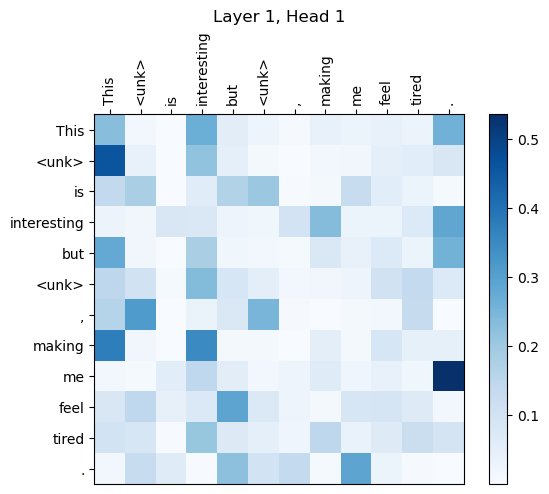

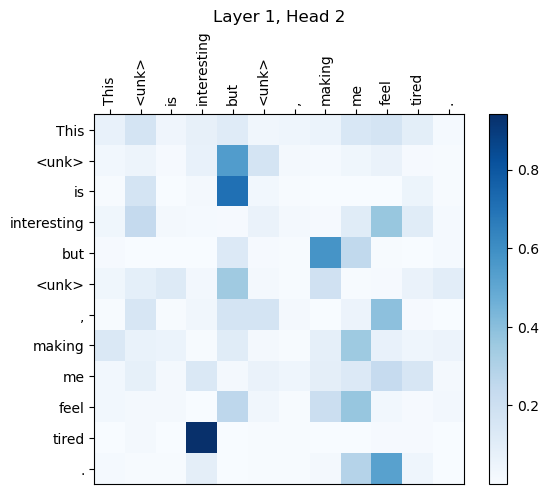

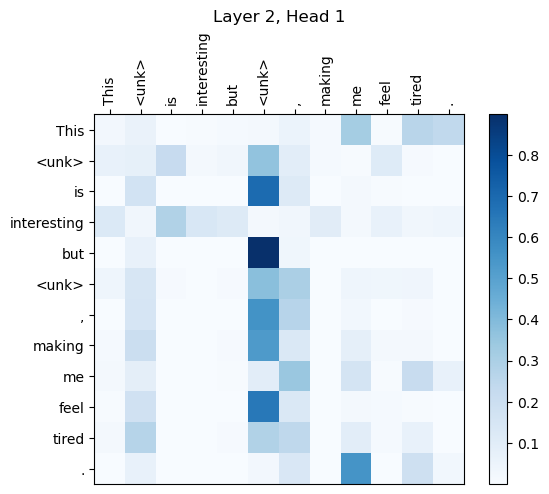

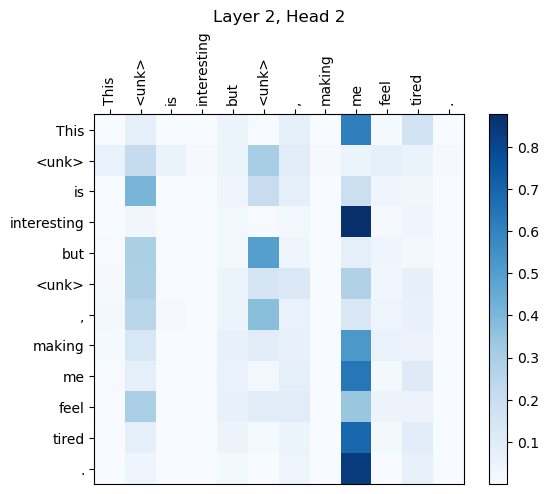

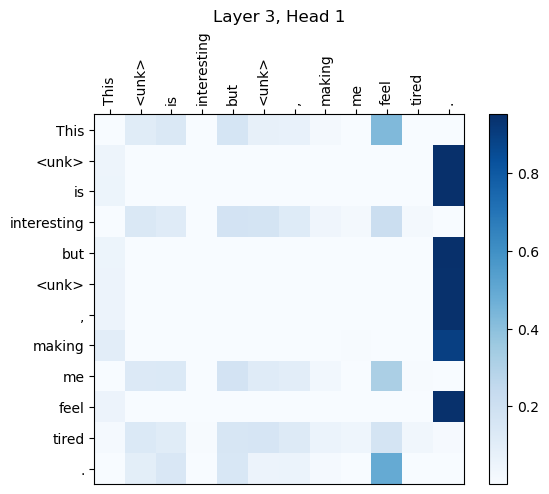

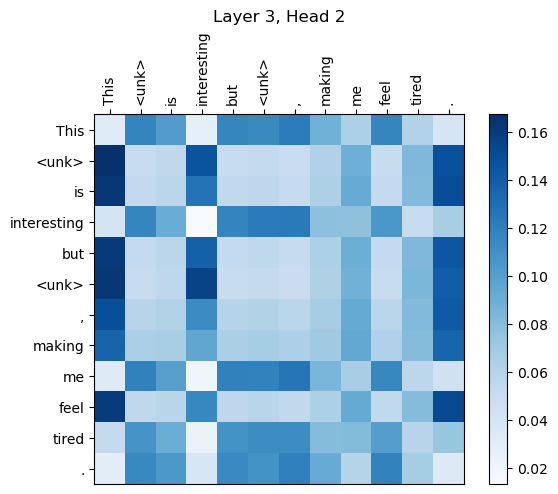

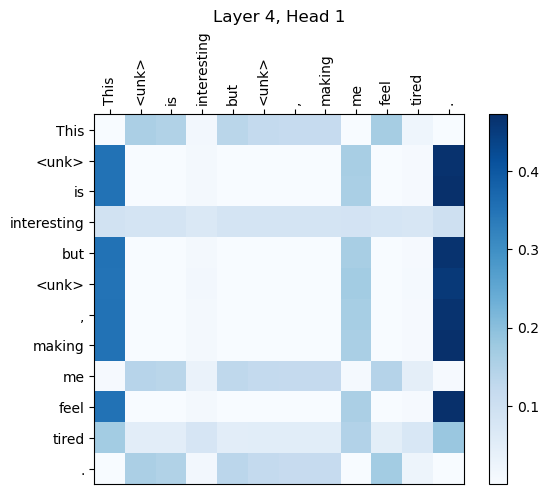

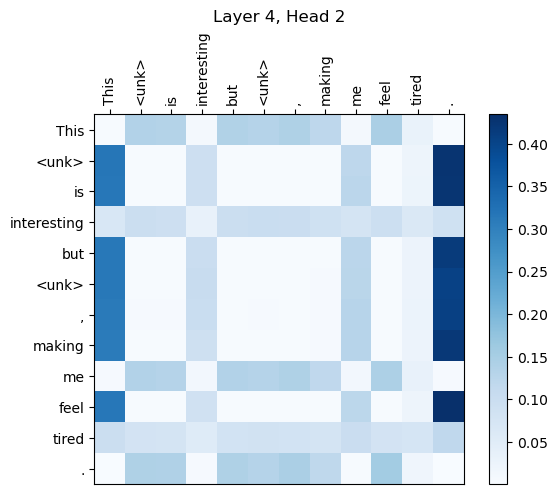

In [16]:
import matplotlib.pyplot as plt
import torch

class Utilities:
    def __init__(self, tokenizer, model, model_type='encoder'):
        self.tokenizer = tokenizer
        self.model = model
        self.model_type = model_type  # 'encoder' or 'decoder'

    def sanity_check(self, sentence, block_size):
        # Encode the sentence using the tokenizer
        wordids = self.tokenizer.encode(sentence)
        seq_len = min(len(wordids), block_size)

        # Prepare the input tensor for the model
        padded_sentence = wordids[:block_size] + [0] * (block_size - len(wordids))
        input_tensor = torch.tensor(padded_sentence, dtype=torch.long).unsqueeze(0)
        input_tensor = input_tensor[:, :seq_len]  # Truncate input_tensor to seq_len

        # Move the input tensor to the same device as the model
        device = next(self.model.parameters()).device
        input_tensor = input_tensor.to(device)

        # Create attention mask based on model_type
        if self.model_type == 'encoder':
            # For encoder, create padding mask (True where input is padding)
            attention_mask = (input_tensor == 0).bool()
        elif self.model_type == 'decoder':
            # For decoder, create combined causal mask and padding mask
            # Padding mask
            padding_mask = (input_tensor == 0).bool()  # Shape: (batch_size, seq_len)
            # Causal mask
            causal_mask = torch.triu(torch.ones(seq_len, seq_len, device=device), diagonal=1).bool()
            causal_mask = causal_mask.unsqueeze(0)  # Shape: (1, seq_len, seq_len)
            # Combine masks
            attention_mask = causal_mask
            if padding_mask.any():
                # Adjust padding mask shape
                padding_mask = padding_mask.unsqueeze(1).expand(-1, seq_len, -1)  # Shape: (batch_size, seq_len, seq_len)
                attention_mask = attention_mask | padding_mask
        else:
            raise ValueError("Invalid model_type. Choose 'encoder' or 'decoder'.")

        attention_mask = attention_mask.to(device)

        # Display input tensor shape
        print("Input tensor shape:", input_tensor.shape)

        # Process the input tensor through the model with attention mask
        with torch.no_grad():
            _, attn_maps = self.model(input_tensor, mask=attention_mask)

        # Display the number of attention maps (number of layers)
        print("Number of attention maps:", len(attn_maps))

        # Get token texts for visualization
        token_ids = input_tensor[0].cpu().numpy()
        token_texts = [self.tokenizer.decode([tid]) for tid in token_ids]

        # Visualize and save the attention maps
        for j, attn_map in enumerate(attn_maps):
            att_map = attn_map.squeeze(0).detach()  # Remove batch dimension, shape: (n_head, seq_len, seq_len)
            n_head = att_map.shape[0]
            
            # Iterate over each attention head
            for h in range(n_head):
                head_attn = att_map[h]  # Shape: (seq_len, seq_len)
                
                # Check if the attention probabilities sum to 1 over rows
                total_prob_over_rows = torch.sum(head_attn, dim=1)
                if torch.any(total_prob_over_rows < 0.99) or torch.any(total_prob_over_rows > 1.01):
                    print(f"Failed normalization test in layer {j + 1}, head {h + 1}: probabilities do not sum to 1.0 over rows")
                    print("Total probability over rows:", total_prob_over_rows.cpu().numpy())
                
                # Move attention map to CPU and convert to NumPy array
                head_attn_numpy = head_attn.cpu().numpy()
                
                # Create a heatmap of the attention map
                fig, ax = plt.subplots()
                cax = ax.imshow(head_attn_numpy, cmap='Blues', interpolation='nearest')
                ax.xaxis.tick_top()
                fig.colorbar(cax, ax=ax)
                plt.title(f"Layer {j + 1}, Head {h + 1}")
                plt.xticks(range(seq_len), token_texts, rotation=90)
                plt.yticks(range(seq_len), token_texts)
                
                # Save the plot
                plt.savefig(f"attention_map_layer{j + 1}_head{h + 1}.png")
                
                # Show the plot
                plt.show()

     
utilities = Utilities(tokenizer, encoder)
sentence = "This assignment is interesting but time-consuming, making me feel tired."  
utilities.sanity_check(sentence, block_size)

In [2]:
import torch
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
import os

from tokenizer import SimpleTokenizer
from dataset import SpeechesClassificationDataset, LanguageModelingDataset
from transformer import *

seed = 42

if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

""" Hyperparameters to use for training to roughly match 
the numbers mentioned in the assignment description """
batch_size = 16  # Number of independent sequences  we will process in parallel
block_size = 32  # Maximum context length for predictions
learning_rate = 1e-3  # Learning rate for the optimizer
n_embd = 64  # Embedding dimension
n_head = 2  # Number of attention heads
n_layer = 4  # Number of transformer layers


eval_interval = 100  # How often to evaluate train and test perplexity during training
max_iters = 500 # For language modeling, we can process all the batches for the entire dataset, but that takes a while, so we'll limit it to 500 iterations. For batch size of 16 and block size of  32, this is roughly, this is  500 * 16 * 32 = 256000 tokens, SOTA LMs are trained on trillions of tokens, so this is a very small dataset.
eval_iters = 200  # Number of iterations to evaluate perplexity on the test set


## classifier training hyperparameters. It is a simple 1 hidden layer feedforward network, with input 
## size of 64, hidden size of 50 and output size of 3.

n_input = 64  # Input size for the classifier, should match the embedding size of the transformer
n_hidden = 100  # Hidden size for the classifier
n_output = 3  # Output size for the classifier, we have 3 classes
epochs_CLS = 15 # epochs for classifier training

def load_texts(directory):
    """
    This function loads all texts from the specified directory, ignoring any files with "test" in their name. The text is used for "training" the tokenizer. Since our tokenizer is simple, we don't need to do any training, but we still need to ignore the test data. 
    """

    texts = []
    files = os.listdir(directory)
    for filename in files: 
        if "test" in filename:  ## don't "read test files"
            continue
        with open(os.path.join(directory, filename), 'r', encoding='utf-8') as file:
            texts.append(file.read())
    return texts



def collate_batch(batch):
    """ Collate a batch of data into a single tensor with padding."""
    data, labels = zip(*batch)  # Separate the data and labels
    # Pad sequences to the fixed length
    padded_sequences = pad_sequence(data, batch_first=True, padding_value=0)
    padded_sequences = padded_sequences[:, :block_size]  # Truncate if longer
    # Add padding if shorter
    padded_sequences = torch.nn.functional.pad(padded_sequences, (0, max(0, block_size - padded_sequences.shape[1])), "constant", 0)
    labels = torch.stack(labels)  
    return padded_sequences, labels

def compute_classifier_accuracy(encoder, classifier, data_loader):
    """Compute the accuracy of the classifier on the data in data_loader."""
    encoder.eval()
    classifier.eval()
    total_correct = 0
    total_samples = 0
    with torch.no_grad():
        for X, Y in data_loader:
            X, Y = X.to(device), Y.to(device)
            mask = (X != 0).float().to(device)

            # Forward pass through encoder
            encoder_output, _ = encoder(X)
            x = (encoder_output * mask.unsqueeze(-1)).sum(dim=1) / mask.sum(dim=1, keepdim=True)

            # Forward pass through classifier
            outputs = classifier(x)
            _, predicted = torch.max(outputs.data, 1)
            total_correct += (predicted == Y).sum().item()
            total_samples += Y.size(0)
    accuracy = (100 * total_correct / total_samples)
    encoder.train()
    classifier.train()
    return accuracy

def compute_perplexity(decoderLMmodel, data_loader, eval_iters=100):
    """ Compute the perplexity of the decoderLMmodel on the data in data_loader.
    Make sure to use the cross entropy loss for the decoderLMmodel.
    """
    decoderLMmodel.eval()
    total_loss = 0.0
    total_tokens = 0
    criterion = nn.CrossEntropyLoss(reduction='sum')
    with torch.no_grad():
        for i, (X, Y) in enumerate(data_loader):
            X, Y = X.to(device), Y.to(device)
            logits, _ = decoderLMmodel(X)
            logits = logits.view(-1, logits.size(-1))
            Y = Y.view(-1)
            loss = criterion(logits, Y)
            total_loss += loss.item()
            total_tokens += Y.size(0)
            if (i + 1) >= eval_iters:
                break
    avg_loss = total_loss / total_tokens
    perplexity = torch.exp(torch.tensor(avg_loss))
    decoderLMmodel.train()
    return perplexity.item()


def train_CLS_model(tokenizer, train_CLS_loader, test_CLS_loader, epochs_CLS):
    def create_mask(x):
        # x: (batch_size, seq_len)
        mask = (x != 0).float()
        return mask

    # Initialize the Encoder
    encoder = TransformerEncoder(
        vocab_size=tokenizer.vocab_size,
        n_embd=n_embd,
        n_head=n_head,
        n_layer=n_layer,
        max_seq_len=block_size
    ).to(device)

    # Initialize the Classifier
    classifier = FNNClassifier(
        n_input=n_embd,
        n_hidden=n_hidden,
        n_output=n_output
    ).to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(
        list(encoder.parameters()) + list(classifier.parameters()),
        lr=learning_rate,
        weight_decay=1e-4
    )
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)
    
    for epoch in range(epochs_CLS):
        epoch_loss = 0
        total_correct = 0
        total_samples = 0

        for xb, yb in train_CLS_loader:
            xb, yb = xb.to(device), yb.to(device)
            mask = create_mask(xb)

            encoder_output, _ = encoder(xb)  # Encode the input
            x = (encoder_output * mask.unsqueeze(-1)).sum(dim=1) / mask.sum(dim=1, keepdim=True)   # Average the encoder output
            outputs = classifier(x)          # Get the classifier output

            loss = criterion(outputs, yb)    # Loss

            # Optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Compute statistics
            epoch_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_correct += (predicted == yb).sum().item()
            total_samples += yb.size(0)

        epoch_accuracy = 100 * total_correct / total_samples
        epoch_loss_avg = epoch_loss / len(train_CLS_loader)

        # Compute test accuracy
        test_accuracy = compute_classifier_accuracy(encoder, classifier, test_CLS_loader)
        print(f"Epoch [{epoch+1}/{epochs_CLS}], Loss: {epoch_loss_avg:.4f}, "
              f"Train Accuracy: {epoch_accuracy:.2f}%, Test Accuracy: {test_accuracy:.2f}%")

        # Adjust learning rate
        scheduler.step(epoch_loss_avg)
    
    return encoder, classifier

def train_LM_model(tokenizer, train_LM_loader, test_LM_loaders, max_iters):
    # Initialize the Decoder
    decoder = TransformerDecoder(
        vocab_size=tokenizer.vocab_size,
        n_embd=n_embd,
        n_head=n_head,
        n_layer=n_layer,
        max_seq_len=block_size
    ).to(device)

    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(
        decoder.parameters(),
        lr=learning_rate
    )

    # Training loop
    total_steps = 0
    total_loss = 0.0
    decoder.train()

    for i, (xb, yb) in enumerate(train_LM_loader):
        if total_steps >= max_iters:
            break
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()

        # Forward pass through the decoder
        logits, _ = decoder(xb)
        logits = logits.view(-1, logits.size(-1))
        yb = yb.view(-1)

        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_steps += 1

        # Every 100 iterations, compute and print perplexity
        if total_steps % 100 == 0:
            avg_loss = total_loss / total_steps
            train_perplexity = compute_perplexity(decoder, train_LM_loader, eval_iters)
            print(f"Iteration [{total_steps}/{max_iters}], "
                  f"Loss: {avg_loss:.4f}, Train Perplexity: {train_perplexity:.2f}")

            # Compute test perplexities
            for name, test_loader in test_LM_loaders.items():
                test_perplexity = compute_perplexity(decoder, test_loader, eval_iters)
                print(f"Test Perplexity on {name}: {test_perplexity:.2f}")
            print("-" * 50)

    # Return the trained decoder
    return decoder

print("Loading data and creating tokenizer ...")
texts = load_texts('speechesdataset')
tokenizer = SimpleTokenizer(' '.join(texts)) # create a tokenizer from the data
print("Vocabulary size is", tokenizer.vocab_size)

inputfile = "speechesdataset/train_LM.txt"
with open(inputfile, 'r', encoding='utf-8') as f:
    lmtrainText = f.read()
train_LM_dataset = LanguageModelingDataset(tokenizer, lmtrainText,  block_size)
train_LM_loader = DataLoader(train_LM_dataset, batch_size=batch_size, shuffle=True)

# for the language modeling task, you will iterate over the training data for a fixed number of iterations like this:
# LM training code here
test_files = {
    "Obama": "speechesdataset/test_LM_obama.txt",
    "H_Bush": "speechesdataset/test_LM_hbush.txt",
    "W_Bush": "speechesdataset/test_LM_wbush.txt"
}
test_LM_loaders = {}
for name, filepath in test_files.items():
    with open(filepath, 'r', encoding='utf-8') as f:
        test_text = f.read()
    test_dataset = LanguageModelingDataset(tokenizer, test_text, block_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    test_LM_loaders[name] = test_loader
decoder = train_LM_model(tokenizer, train_LM_loader, test_LM_loaders, max_iters)

Loading data and creating tokenizer ...
Vocabulary size is 5755
Iteration [100/500], Loss: 6.8774, Train Perplexity: 595.86
Test Perplexity on Obama: 726.98
Test Perplexity on H_Bush: 746.45
Test Perplexity on W_Bush: 813.58
--------------------------------------------------
Iteration [200/500], Loss: 6.5956, Train Perplexity: 472.06
Test Perplexity on Obama: 622.99
Test Perplexity on H_Bush: 637.31
Test Perplexity on W_Bush: 701.42
--------------------------------------------------
Iteration [300/500], Loss: 6.3888, Train Perplexity: 319.66
Test Perplexity on Obama: 464.31
Test Perplexity on H_Bush: 493.86
Test Perplexity on W_Bush: 548.28
--------------------------------------------------
Iteration [400/500], Loss: 6.1900, Train Perplexity: 225.84
Test Perplexity on Obama: 405.35
Test Perplexity on H_Bush: 434.88
Test Perplexity on W_Bush: 485.70
--------------------------------------------------
Iteration [500/500], Loss: 6.0134, Train Perplexity: 166.37
Test Perplexity on Obama: 36

Input tensor shape: torch.Size([1, 6])
Number of attention maps: 4
tensor([[ 1.8150,    -inf,    -inf,    -inf,    -inf,    -inf],
        [-1.5558,  0.8836,    -inf,    -inf,    -inf,    -inf],
        [-0.1746, -0.3458,  3.2036,    -inf,    -inf,    -inf],
        [ 0.8152, -0.6727,  2.0454, -0.8891,    -inf,    -inf],
        [-0.8652,  1.5705, -0.0399,  1.3469,  0.3352,    -inf],
        [   -inf,  0.2465,  0.5423, -1.4817,  1.3126,  1.6513]],
       device='mps:0')
Failed normalization test in layer 1, head 1: probabilities do not sum to 1.0 over rows
Total probability over rows: [-inf -inf -inf -inf -inf -inf]


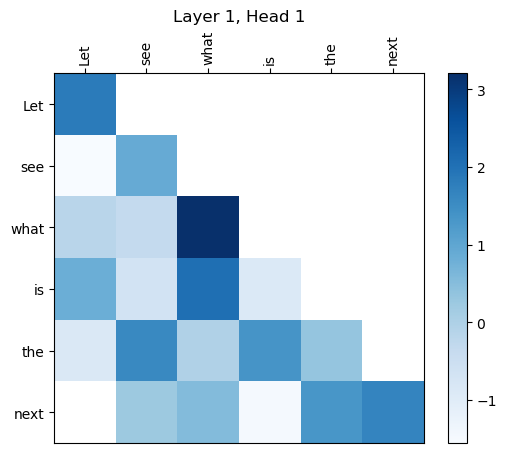

tensor([[-0.1090,    -inf,    -inf,    -inf,    -inf,    -inf],
        [-2.1744,  0.6571,    -inf,    -inf,    -inf,    -inf],
        [-0.7824,  0.2522,  1.1110,    -inf,    -inf,    -inf],
        [-1.4929,  0.5722, -1.3041,  2.9570,    -inf,    -inf],
        [-0.3253, -0.6843,  0.1425, -0.3688,  2.7862,    -inf],
        [   -inf,  0.0070,  0.0143, -0.3963,  0.8976,  0.7414]],
       device='mps:0')
Failed normalization test in layer 1, head 2: probabilities do not sum to 1.0 over rows
Total probability over rows: [-inf -inf -inf -inf -inf -inf]


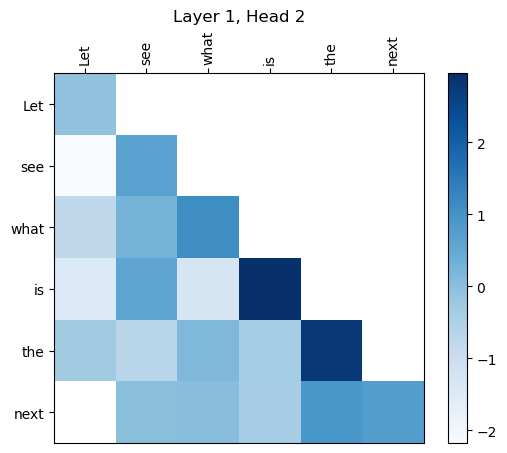

tensor([[ 0.3636,    -inf,    -inf,    -inf,    -inf,    -inf],
        [-0.9687, -1.4492,    -inf,    -inf,    -inf,    -inf],
        [-0.7189, -0.9737,  1.8350,    -inf,    -inf,    -inf],
        [-1.1912, -0.4341,  1.7609,  0.9740,    -inf,    -inf],
        [-1.0630, -0.1625,  0.0619,  0.8123, -1.0388,    -inf],
        [   -inf, -0.1842,  0.3099,  0.0437,  0.4193,  1.0725]],
       device='mps:0')
Failed normalization test in layer 2, head 1: probabilities do not sum to 1.0 over rows
Total probability over rows: [-inf -inf -inf -inf -inf -inf]


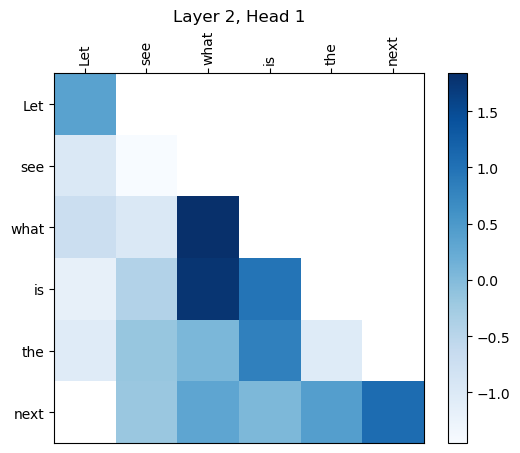

tensor([[ 0.0700,    -inf,    -inf,    -inf,    -inf,    -inf],
        [-0.0464,  0.5621,    -inf,    -inf,    -inf,    -inf],
        [-0.9061, -0.8089,  4.8597,    -inf,    -inf,    -inf],
        [ 0.2324,  1.0880, -0.5792, -0.1988,    -inf,    -inf],
        [-0.1552, -0.6618, -0.1276, -0.5851,  3.8072,    -inf],
        [   -inf,  0.7070,  0.2357,  0.7686, -0.1671,  0.9786]],
       device='mps:0')
Failed normalization test in layer 2, head 2: probabilities do not sum to 1.0 over rows
Total probability over rows: [-inf -inf -inf -inf -inf -inf]


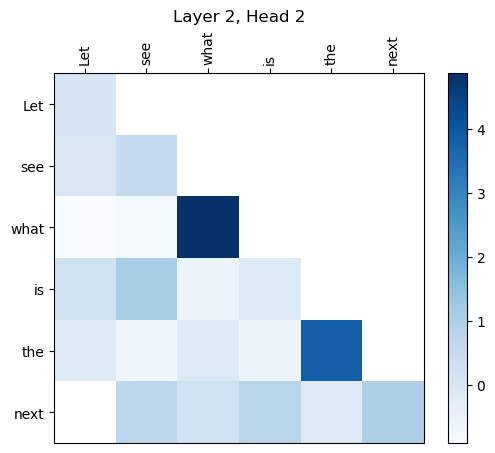

tensor([[-1.2682,    -inf,    -inf,    -inf,    -inf,    -inf],
        [-0.1847, -0.0601,    -inf,    -inf,    -inf,    -inf],
        [-1.5543, -1.0252,  0.0942,    -inf,    -inf,    -inf],
        [ 1.4131,  0.8114,  0.5557, -1.0235,    -inf,    -inf],
        [ 1.0274,  0.6082,  0.7974, -0.3482, -1.0599,    -inf],
        [   -inf, -0.6284, -1.7989,  0.2690,  1.1320,  1.1348]],
       device='mps:0')
Failed normalization test in layer 3, head 1: probabilities do not sum to 1.0 over rows
Total probability over rows: [-inf -inf -inf -inf -inf -inf]


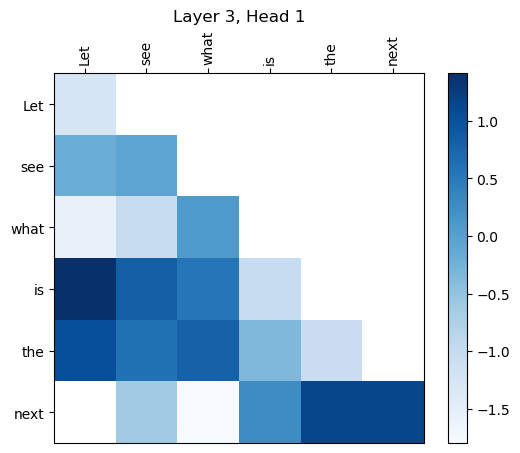

tensor([[-0.3678,    -inf,    -inf,    -inf,    -inf,    -inf],
        [ 0.1517, -0.0445,    -inf,    -inf,    -inf,    -inf],
        [ 0.8887, -0.2031,  0.8064,    -inf,    -inf,    -inf],
        [ 0.4211, -0.6892, -0.9512, -1.3131,    -inf,    -inf],
        [-0.6046, -1.2155, -0.0428, -0.1801,  1.2939,    -inf],
        [   -inf, -1.7525, -1.5840, -0.9838,  4.2606,  1.2755]],
       device='mps:0')
Failed normalization test in layer 3, head 2: probabilities do not sum to 1.0 over rows
Total probability over rows: [-inf -inf -inf -inf -inf -inf]


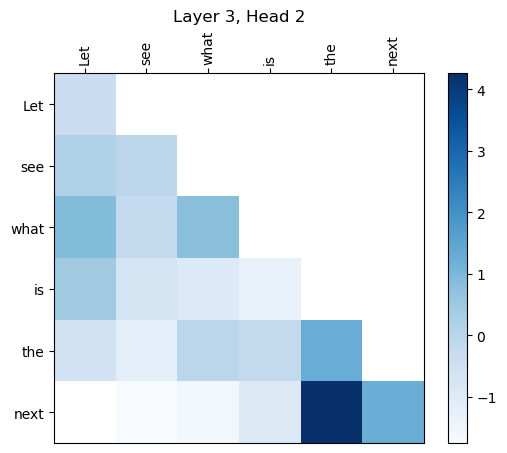

tensor([[-1.5986e+00,        -inf,        -inf,        -inf,        -inf,
                -inf],
        [-6.1887e-01, -7.8526e-01,        -inf,        -inf,        -inf,
                -inf],
        [-2.8391e+00, -2.8169e+00,  1.4591e+00,        -inf,        -inf,
                -inf],
        [-7.8914e-01, -2.3835e-01,  3.4536e-01, -7.2505e-03,        -inf,
                -inf],
        [ 7.3077e-01,  1.2849e+00,  2.6646e-01, -6.5015e-01,  9.5821e-01,
                -inf],
        [       -inf, -5.2473e-05,  4.1870e-01, -1.0456e+00,  2.2197e-01,
          1.0271e+00]], device='mps:0')
Failed normalization test in layer 4, head 1: probabilities do not sum to 1.0 over rows
Total probability over rows: [-inf -inf -inf -inf -inf -inf]


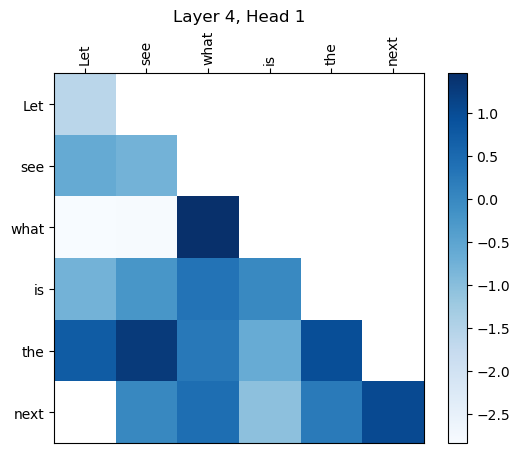

tensor([[-0.1919,    -inf,    -inf,    -inf,    -inf,    -inf],
        [-1.0106,  0.8403,    -inf,    -inf,    -inf,    -inf],
        [ 0.4410, -1.3156, -0.2655,    -inf,    -inf,    -inf],
        [-0.1759,  0.4437, -1.0522, -0.2621,    -inf,    -inf],
        [ 0.5010, -0.8322, -0.6400, -0.0665,  1.5126,    -inf],
        [   -inf, -0.8110, -0.3025,  0.5428, -0.4627, -0.9570]],
       device='mps:0')
Failed normalization test in layer 4, head 2: probabilities do not sum to 1.0 over rows
Total probability over rows: [-inf -inf -inf -inf -inf -inf]


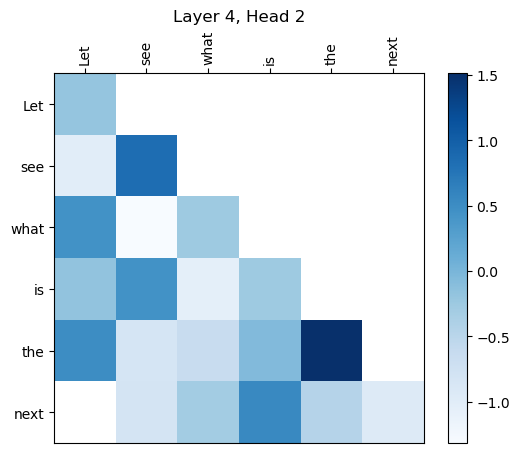

In [4]:
import matplotlib.pyplot as plt
import torch

class Utilities:
    def __init__(self, tokenizer, model, model_type='encoder'):
        self.tokenizer = tokenizer
        self.model = model
        self.model_type = model_type  # 'encoder' or 'decoder'

    def sanity_check(self, sentence, block_size):
        # Encode the sentence using the tokenizer
        wordids = self.tokenizer.encode(sentence)
        seq_len = min(len(wordids), block_size)

        # Prepare the input tensor for the model
        padded_sentence = wordids[:block_size] + [0] * (block_size - len(wordids))
        input_tensor = torch.tensor(padded_sentence, dtype=torch.long).unsqueeze(0)
        input_tensor = input_tensor[:, :seq_len]  # Truncate input_tensor to seq_len

        # Move the input tensor to the same device as the model
        device = next(self.model.parameters()).device
        input_tensor = input_tensor.to(device)

        # Create attention mask based on model_type
        if self.model_type == 'encoder':
            # For encoder, create padding mask (True where input is padding)
            attention_mask = (input_tensor == 0).bool()
        elif self.model_type == 'decoder':
            # For decoder, create combined causal mask and padding mask
            # Padding mask
            padding_mask = (input_tensor == 0).bool()  # Shape: (batch_size, seq_len)
            # Causal mask
            causal_mask = torch.triu(torch.ones(seq_len, seq_len, device=device), diagonal=1).bool()
            causal_mask = causal_mask.unsqueeze(0)  # Shape: (1, seq_len, seq_len)
            # Combine masks
            attention_mask = causal_mask
            if padding_mask.any():
                # Adjust padding mask shape
                padding_mask = padding_mask.unsqueeze(1).expand(-1, seq_len, -1)  # Shape: (batch_size, seq_len, seq_len)
                attention_mask = attention_mask | padding_mask
        else:
            raise ValueError("Invalid model_type. Choose 'encoder' or 'decoder'.")

        attention_mask = attention_mask.to(device)

        # Display input tensor shape
        print("Input tensor shape:", input_tensor.shape)

        # Process the input tensor through the model with attention mask
        with torch.no_grad():
            _, attn_maps = self.model(input_tensor, mask=attention_mask)

        # Display the number of attention maps (number of layers)
        print("Number of attention maps:", len(attn_maps))

        # Get token texts for visualization
        token_ids = input_tensor[0].cpu().numpy()
        token_texts = [self.tokenizer.decode([tid]) for tid in token_ids]

        # Visualize and save the attention maps
        for j, attn_map in enumerate(attn_maps):
            att_map = attn_map.squeeze(0).detach()  # Remove batch dimension, shape: (n_head, seq_len, seq_len)
            n_head = att_map.shape[0]
            
            # Iterate over each attention head
            for h in range(n_head):
                head_attn = att_map[h]  # Shape: (seq_len, seq_len)
                print(head_attn)
                
                # Check if the attention probabilities sum to 1 over rows
                total_prob_over_rows = torch.sum(head_attn, dim=1)
                if torch.any(total_prob_over_rows < 0.99) or torch.any(total_prob_over_rows > 1.01):
                    print(f"Failed normalization test in layer {j + 1}, head {h + 1}: probabilities do not sum to 1.0 over rows")
                    print("Total probability over rows:", total_prob_over_rows.cpu().numpy())
                
                # Move attention map to CPU and convert to NumPy array
                head_attn_numpy = head_attn.cpu().numpy()
                
                # Create a heatmap of the attention map
                fig, ax = plt.subplots()
                cax = ax.imshow(head_attn_numpy, cmap='Blues', interpolation='nearest')
                ax.xaxis.tick_top()
                fig.colorbar(cax, ax=ax)
                plt.title(f"Layer {j + 1}, Head {h + 1}")
                plt.xticks(range(seq_len), token_texts, rotation=90)
                plt.yticks(range(seq_len), token_texts)
                
                # Save the plot
                plt.savefig(f"attention_map_layer{j + 1}_head{h + 1}.png")
                
                # Show the plot
                plt.show()
       
utilities = Utilities(tokenizer, decoder, 'decoder')
sentence = "Let see what is the next step."
utilities.sanity_check(' '.join(sentence.split()[:-1]), block_size)